Для определения, справка 405 это или нет.

Вариант с pytorch augmentation понимает только 8-bit png



In [26]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import cv2
import datetime as dt

import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms, utils
from torchvision.transforms.transforms import RandomAutocontrast, Grayscale, RandomRotation, RandomPerspective, RandomInvert
from torchvision.transforms import Resize
from torchvision.io import read_image, ImageReadMode
from torch import nn

from skimage import io

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

import plotly.io as pio
from plotly.figure_factory import create_annotated_heatmap

plt.ion()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
SOURCE_DIR = 'drive/MyDrive/Colab Notebooks/data/images/'
TEST_DIR = 'drive/MyDrive/Colab Notebooks/data/test/'
VALID_SIZE = .5
BATCH_SIZE = 16
T_BATCH_SIZE = 16
IMG_SIZE = 512
IMG_CHANNELS = 1

In [7]:
images = []
is_cert = []
for filename in os.listdir(SOURCE_DIR):
  images.append(filename)
  if '405___' in filename:
    is_cert.append(1)
  else:
    is_cert.append(0)
descr = pd.DataFrame(data={
    'file': images,
    'target': is_cert})

In [8]:
descr.head()

,file,target
0,402___136d64ae8d174354bc2af057d77f93a7.png,0
1,402___335f83b3a37b403fb31088c8132f74b4.png,0
2,402___96f14679afdb4078bb277152b1b6c215.png,0
3,402___87e9b407c1e5485e9872ff3acf484731.png,0
4,402___fa2f8d33a9cc4318b720f1086df67e3a.png,0


In [9]:
def preprocessing(path):
  img_in = cv2.imread(path)
  img = cv2.resize(img_in, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_AREA)
  imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(imgray, 127, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
  cont = cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
  return torch.tensor(cont, dtype=torch.float32)

In [10]:
class Certs(Dataset):
    def __init__(self, annotations, img_dir, transform, target_transform=None):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = preprocessing(img_path)
        #image = read_image(img_path, ImageReadMode.RGB).to(torch.float32)
        label = np.uint8(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
#transformer = transforms.Compose([
#    transforms.Resize((512, 512)),
#    Grayscale(3), RandomAutocontrast(),
#    RandomRotation(90), RandomPerspective(),
#    RandomInvert()]
#)
transformer = None
cert_dataset = Certs(annotations=descr,
                                    img_dir=SOURCE_DIR, transform=transformer)
train_size = int(VALID_SIZE * len(cert_dataset))
test_size = len(cert_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(cert_dataset, [train_size, test_size])

In [12]:
look_flow = DataLoader(cert_dataset, batch_size=8, shuffle=True, num_workers=1,
                           pin_memory=True)

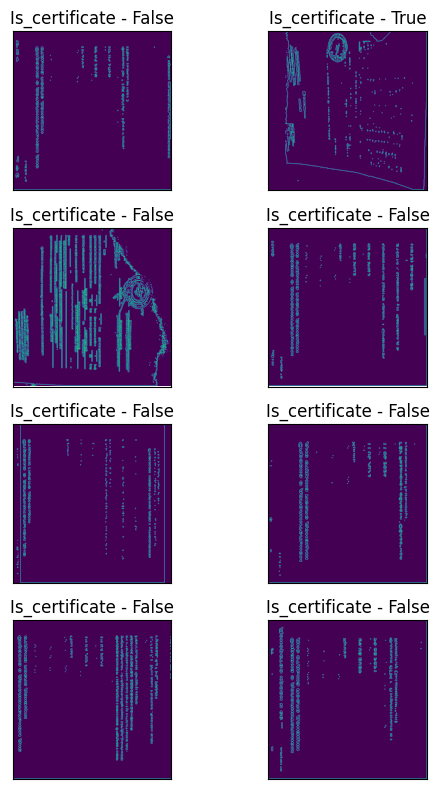

In [13]:
fig = plt.figure(figsize=(8,8))
for IMG, label in (look_flow):
    for i in range(8):
        fig.add_subplot(4, 2, i+1)
        plt.imshow(IMG[i].to(torch.uint8).permute(1, 0))#permute(1, 2, 0))
        plt.title(f'Is_certificate - {bool(label[i])}')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    break

In [14]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 3, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=1),
            nn.Conv2d(3, 6, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=1),
            nn.Conv2d(6, 18, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=1),
            nn.Conv2d(18, 24, (5,5)),
            nn.ReLU(),
            nn.AvgPool2d(5, stride=2),
            #nn.Conv2d(64, 128, (5,5)),
            #nn.ReLU(),
            #nn.AvgPool2d(5, stride=2),
            nn.Flatten(),
            #nn.LazyLinear(1024),
            #nn.Tanh(),
            nn.LazyLinear(128),
            nn.Tanh(),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(1),
            nn.Sigmoid()
        )
        #self.float()

    def forward(self, x):
        return self.layers(x)

model = MyNN().to(device)
print(model)

MyNN(
  (layers): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=5, stride=1, padding=0)
    (3): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=5, stride=1, padding=0)
    (6): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=5, stride=1, padding=0)
    (9): Conv2d(18, 24, kernel_size=(5, 5), stride=(1, 1))
    (10): ReLU()
    (11): AvgPool2d(kernel_size=5, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): LazyLinear(in_features=0, out_features=128, bias=True)
    (14): Tanh()
    (15): LazyLinear(in_features=0, out_features=32, bias=True)
    (16): ReLU()
    (17): LazyLinear(in_features=0, out_features=1, bias=True)
    (18): Sigmoid()
  )
)


In [15]:
train_flow = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1,
                           pin_memory=True)
valid_flow = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1,
                           pin_memory=True)

In [16]:
w = 0
for i in range(len(train_dataset)):
  w += train_dataset[i][1]
POS_WEIGHT = len(train_dataset) / w
POS_WEIGHT

4.095238095238095

In [17]:
model = MyNN()
pos_weight=torch.tensor(np.array([POS_WEIGHT]))
loss_t = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_v = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_graph = []

n_epochs = 40
for epoch in range(n_epochs):
    train_features, train_labels = next(iter(train_flow))
    train_features = train_features.reshape(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    train_labels = train_labels.unsqueeze(1).to(torch.float32)
    y_pred = model(train_features)
    loss = loss_t(y_pred, train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    BCE = 0
    valid_features, valid_labels = next(iter(valid_flow))
    valid_features = valid_features.reshape(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    valid_labels = valid_labels.unsqueeze(1).to(torch.float32)
    y_pred = model(valid_features)
    BCE = loss_v(y_pred, valid_labels)
    loss_graph.append(BCE.detach().numpy())
    probs = torch.sigmoid(y_pred)
    pre = precision_score(valid_labels.detach().numpy(), y_pred.detach().numpy().round())
    rec = recall_score(valid_labels.detach().numpy(), y_pred.detach().numpy().round())
    acc = accuracy_score(valid_labels.detach().numpy(), y_pred.detach().numpy().round())
    try:
      auc = roc_auc_score(valid_labels.detach().numpy(), probs.detach().numpy())
    except:
      auc = 'only one class'

    print(f'Epoch: {epoch} --- PRECISION {pre} --- RECALL {rec} --- ACCURACY {acc} --- ROC-AUC {auc}')
#plt.plot(loss_graph)

Epoch: 0 --- PRECISION 0.6 --- RECALL 1.0 --- ACCURACY 0.875 --- ROC-AUC 1.0
Epoch: 1 --- PRECISION 0.5555555555555556 --- RECALL 0.8333333333333334 --- ACCURACY 0.6875 --- ROC-AUC 0.8166666666666667
Epoch: 2 --- PRECISION 1.0 --- RECALL 0.5 --- ACCURACY 0.875 --- ROC-AUC 0.8541666666666667
Epoch: 3 --- PRECISION 1.0 --- RECALL 0.4 --- ACCURACY 0.8125 --- ROC-AUC 0.6363636363636364
Epoch: 4 --- PRECISION 0.0 --- RECALL 0.0 --- ACCURACY 0.4375 --- ROC-AUC 0.38095238095238093
Epoch: 5 --- PRECISION 0.0 --- RECALL 0.0 --- ACCURACY 0.625 --- ROC-AUC 0.5166666666666666
Epoch: 6 --- PRECISION 0.0 --- RECALL 0.0 --- ACCURACY 0.875 --- ROC-AUC 0.8928571428571428
Epoch: 7 --- PRECISION 1.0 --- RECALL 0.2 --- ACCURACY 0.75 --- ROC-AUC 0.690909090909091
Epoch: 8 --- PRECISION 0.5 --- RECALL 0.2 --- ACCURACY 0.6875 --- ROC-AUC 0.8545454545454546
Epoch: 9 --- PRECISION 1.0 --- RECALL 0.16666666666666666 --- ACCURACY 0.6875 --- ROC-AUC 0.9333333333333333
Epoch: 10 --- PRECISION 0.0 --- RECALL 0.0 --

In [18]:
now = dt.datetime.now()

point = now.strftime("%Y-%m-%d-%H:%M:%S")
PATH = 'drive/MyDrive/Colab Notebooks/data/model_params-' + point
#torch.save({'epoch': 40,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': BCE
#            }, PATH)
torch.save(model.state_dict(), PATH)

In [19]:
trained_model = MyNN()
#trained_optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.0005)
#checkpoint = torch.load(PATH)
trained_model.load_state_dict(torch.load(PATH))
#trained_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

<All keys matched successfully>

In [20]:
images_test = []
is_cert_test = []
for filename in os.listdir(TEST_DIR):
  images_test.append(filename)
  if '405___' in filename:
    is_cert_test.append(1)
  else:
    is_cert_test.append(0)
descr_test = pd.DataFrame(data={
    'file': images_test,
    'target': is_cert_test})

In [21]:
test_dataset = Certs(annotations=descr_test,
                                    img_dir=TEST_DIR, transform=transformer)
test_flow = DataLoader(test_dataset, batch_size=T_BATCH_SIZE, shuffle=True, num_workers=1,
                           pin_memory=True)


In [22]:
test_features, test_labels = next(iter(test_flow))
test_features = test_features.reshape(T_BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
test_labels = test_labels.unsqueeze(1).to(torch.float32)
y_pred = trained_model(test_features)
probs = torch.sigmoid(y_pred)
pre_test = precision_score(test_labels.detach().numpy(), y_pred.detach().numpy().round())
rec_test = recall_score(test_labels.detach().numpy(), y_pred.detach().numpy().round())
acc_test = accuracy_score(test_labels.detach().numpy(), y_pred.detach().numpy().round())
auc_test = roc_auc_score(test_labels.detach().numpy(), probs.detach().numpy())
#print(f'PREDICTION --- {y_pred} --- TRUE --- {test_labels}')

In [23]:
print(f'PRECISION {pre_test} --- RECALL {rec_test} --- ACCURACY {acc_test} --- ROC-AUC {auc_test}')

PRECISION 1.0 --- RECALL 0.6666666666666666 --- ACCURACY 0.875 --- ROC-AUC 0.8


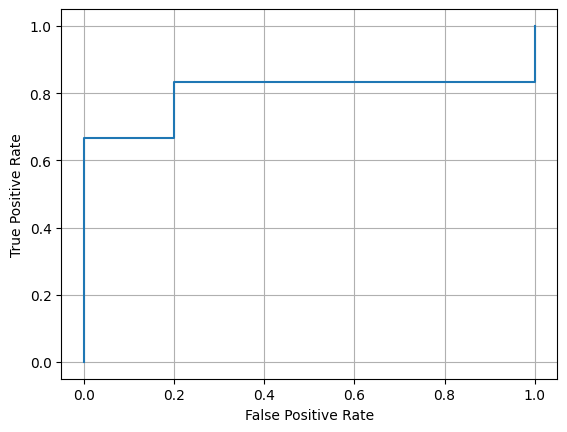

In [24]:
fpr, tpr, thresholds = roc_curve(test_labels.detach().numpy(), probs.detach().numpy())
plt.plot(fpr, tpr)
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
#plt.title(model)

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

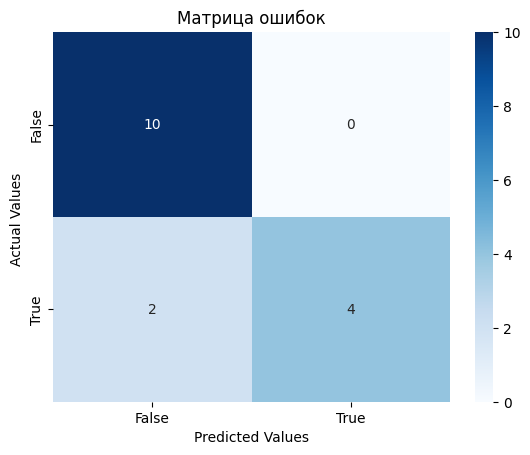

In [30]:
predictions = np.rint(y_pred.detach().numpy())
conf_mx = pd.DataFrame(confusion_matrix(test_labels, predictions))

ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='Blues')

ax.set_title('Матрица ошибок');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])